In [1]:
from selenium import webdriver
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.keys import Keys
from time import sleep
from login import EMAIL
from login import PASSWORD
import re

In [2]:
# login
driver = webdriver.Firefox()
wait = WebDriverWait(driver, 10)
driver.maximize_window()

driver.get("https://pro.urbanize.city/users/sign_in")

wait.until(EC.presence_of_element_located((By.TAG_NAME, "body")))


iframes = driver.find_elements(By.TAG_NAME, "iframe")
if iframes:
    driver.switch_to.frame(iframes[0])

email_input = wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "input[name='email'], input[type='email']")))
email_input.send_keys(EMAIL)

password_input = wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "input[name='password'], input[type='password']")))
password_input.send_keys(PASSWORD)

login_button = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "button.btn.prime[actionlogin]")))
login_button.click()


wait.until(EC.presence_of_element_located((By.TAG_NAME, "body")))

driver.switch_to.default_content()
wait.until(EC.visibility_of_element_located((By.XPATH, "//a[contains(@class, 'border-cyan-500') and contains(text(), 'Dashboard')]")))


<selenium.webdriver.remote.webelement.WebElement (session="e81f8623-f345-45d3-a82f-ebba98039f75", element="4fda3d17-aa7c-4a9b-a202-c487308408fd")>

In [3]:
driver.get("https://pro.urbanize.city/los_angeles/projects")

project_links = driver.find_elements(By.CSS_SELECTOR, "ul.grid a[href^='/los_angeles/projects/']")
page_urls = [link.get_attribute('href') for link in project_links]
project_data = {url: {} for url in page_urls}


for url in page_urls:
  driver.get(url)

  wait.until(EC.presence_of_element_located((By.TAG_NAME, "body")))
  
  project_name = wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "h1.text-5xl.font-semibold.text-gray-900.tracking-tight.mb-2"))).text
  project_data[url]['project_name'] = project_name

  grid_exists = len(driver.find_elements(By.CSS_SELECTOR, "ul.grid")) > 0

  if grid_exists:
      grid_links = driver.find_elements(By.CSS_SELECTOR, "ul.grid li a")
      grid_urls = [link.get_attribute('href') for link in grid_links]
      project_data[url]['grid_urls'] = grid_urls
      for article_url in grid_urls:
        driver.get(article_url)
        wait.until(EC.presence_of_element_located((By.TAG_NAME, "body")))

In [4]:
# def get_project_status(driver):

#     return "Status not found"

In [11]:
def pull_data(url):
  driver.get(url)

  #get project name
  wait.until(EC.presence_of_element_located((By.TAG_NAME, "body")))
  project_name = wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "h1.text-5xl.font-semibold.text-gray-900.tracking-tight.mb-2"))).text

  print(f"Project Name: {project_name}")
  

  #get project status
  status = None
  status_elements = driver.find_elements(By.CSS_SELECTOR, "div.flex.space-x-1.w-full > div")
  for element in status_elements:
    bg_div = element.find_element(By.CSS_SELECTOR, "div[class*='w-full'][class*='h-2.5']")
    if "bg-cyan-600" in bg_div.get_attribute("class"):
      status = element.find_element(By.CSS_SELECTOR, "div.text-sm").text

  print(f"Project Status: {status}")


  #get location
  location_header = driver.find_element(By.XPATH, "//h3[contains(@class, 'text-xl') and contains(text(), 'Location')]")
  location_html = location_header.find_element(By.XPATH, "following-sibling::p").get_attribute('innerHTML')
  # location_text = location_element2.text.replace('\n', ', ')
  location_text = re.sub('<[^<]+?>', '', location_html).replace('\n', '').strip()
  # location_text = ', '.join(part.strip() for part in location_text.split(','))

  print(f"Project Location: {location_text}")


  companies = {}
  try:
      companies_div = driver.find_element(By.XPATH, "//h3[contains(@class, 'text-xl') and contains(text(), 'Companies')]/ancestor::div[contains(@class, 'project-companies')]")
      company_items = companies_div.find_elements(By.XPATH, ".//li[contains(@class, 'py-2')]")
      
      for item in company_items:
          label = item.find_element(By.XPATH, ".//div[contains(@class, 'text-slate-900') and contains(@class, 'font-medium')]").text
          value_div = item.find_element(By.XPATH, ".//div[contains(@class, 'space-y-1')]")
          company_elements = value_div.find_elements(By.CSS_SELECTOR, "div.text-cyan-600.font-semibold a")
          companies[label] = [element.text for element in company_elements]
          print(f"{label}: {', '.join(companies[label])}")
  except:
      print("Companies section not found or could not be parsed")

  project_info = {}
  try:
        information_div = driver.find_element(By.XPATH, "//h3[contains(@class, 'text-xl') and contains(text(), 'Information')]/ancestor::div[contains(@class, '')]")
        info_items = information_div.find_elements(By.XPATH, ".//li[contains(@class, 'py-4')]")
        
        for item in info_items:
            label = item.find_element(By.XPATH, ".//div[contains(@class, 'text-slate-900') and contains(@class, 'font-medium')]").text
            value_div = item.find_element(By.XPATH, ".//div[contains(@class, 'text-slate-800') and contains(@class, 'font-normal')]")
            
            if label == "Project uses":
                uses = [use.text for use in value_div.find_elements(By.XPATH, ".//div/div")]
                project_info[label] = uses
                print(f"Project uses: {', '.join(uses)}")
            else:
                value = value_div.text.strip()
                project_info[label] = value
                print(f"{label}: {value}")
  except:
        print("Information section not found or could not be parsed")

    # Return the extracted data as a dictionary
  result = {
        "project_name": project_name,
        "status": status,
        "location": location_text,
        **companies,
        **project_info
    }
    
  print(result)





# pull_data('https://pro.urbanize.city/los_angeles/projects/d506b9d2/2143-e-violet-street')
# pull_data('https://pro.urbanize.city/los_angeles/projects/7018f2cb/st-ambrose-senior-housing')
pull_data('https://pro.urbanize.city/los_angeles/projects/4d6f451e/huntington-hospital-758-fair-oaks')

Project Name: Huntington Hospital - 758 Fair Oaks
Project Status: Under construction
Project Location: 758 Fair Oaks Avenue    Pasadena, CA 91105
Architect: Mascari Warner Dinh Architects
Developer: Huntington Hospital
Project uses: Office, Parking
Floors (above ground): 4
Podium: No
Construction type: Type 1 2
Floors (below): 3
Parking spaces: 200
Office space (sqft): 100,000
Information section not found or could not be parsed
{'project_name': 'Huntington Hospital - 758 Fair Oaks', 'status': 'Under construction', 'location': '758 Fair Oaks Avenue    Pasadena, CA 91105', 'Architect': ['Mascari Warner Dinh Architects'], 'Developer': ['Huntington Hospital'], 'Project uses': ['Office', 'Parking'], 'Floors (above ground)': '4', 'Podium': 'No', 'Construction type': 'Type 1 2', 'Floors (below)': '3', 'Parking spaces': '200', 'Office space (sqft)': '100,000'}


In [6]:
import requests
from IPython.display import Image, display


Article Title: Updated look for new Huntington Hospital medical offices
Article Subtitle: Out with a motor court, in with a plaza
Article Body: A presentation scheduled for the April 12 meeting of the Pasadena Design Commission offers a look at updated plans for Huntington Hospital's proposed medical office building at 758-766 Fair Oaks Avenue - a short walk east from its main campus.
The project, which would rise from a corner lot at the intersection of Fair Oaks and Fillmore Street, calls for the construction of a four-story edifice featuring just over 100,000 square feet of medical offices and ancillary uses above a three-level subterranean parking garage with capacity for roughly 200 vehicles.
As with the earlier iteration of the project presented to the Design Commission in November 2020, Mascari Warner Dinh has been retained as architect.
"The proposed new building is of a contemporary design with a flat roof, curving and articulated massing, extensive curtain wall glazing juxtap

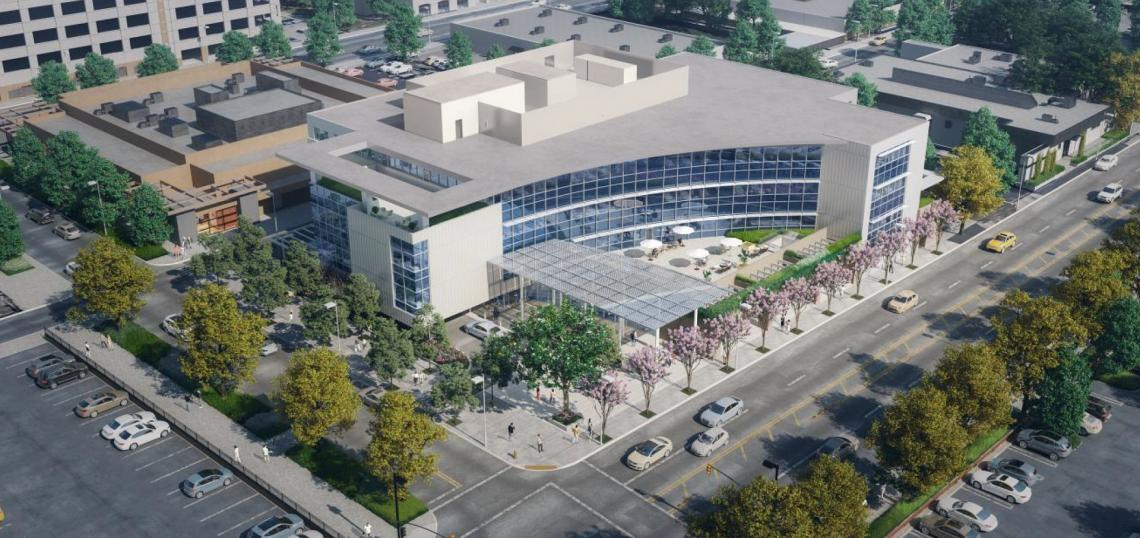

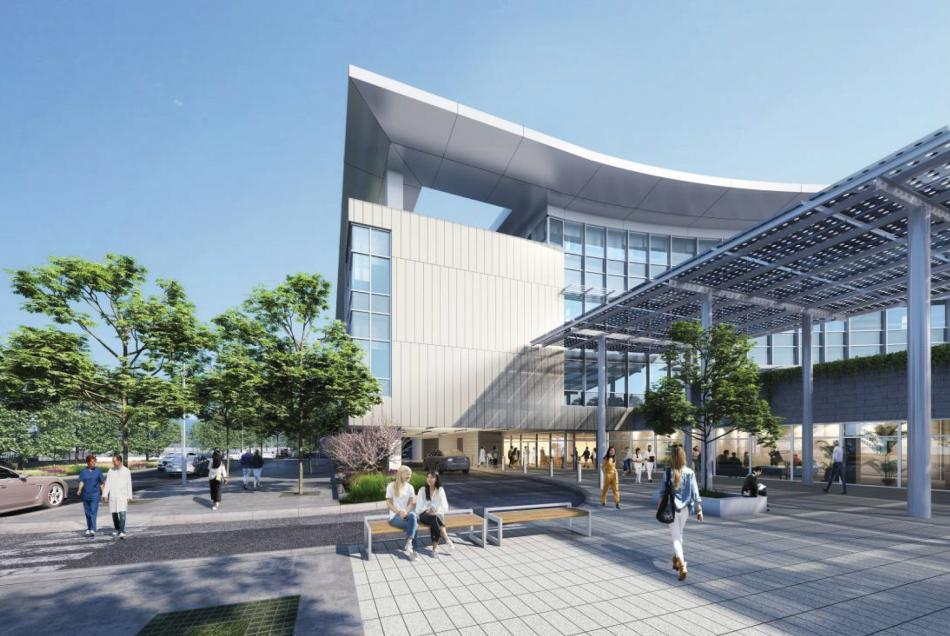

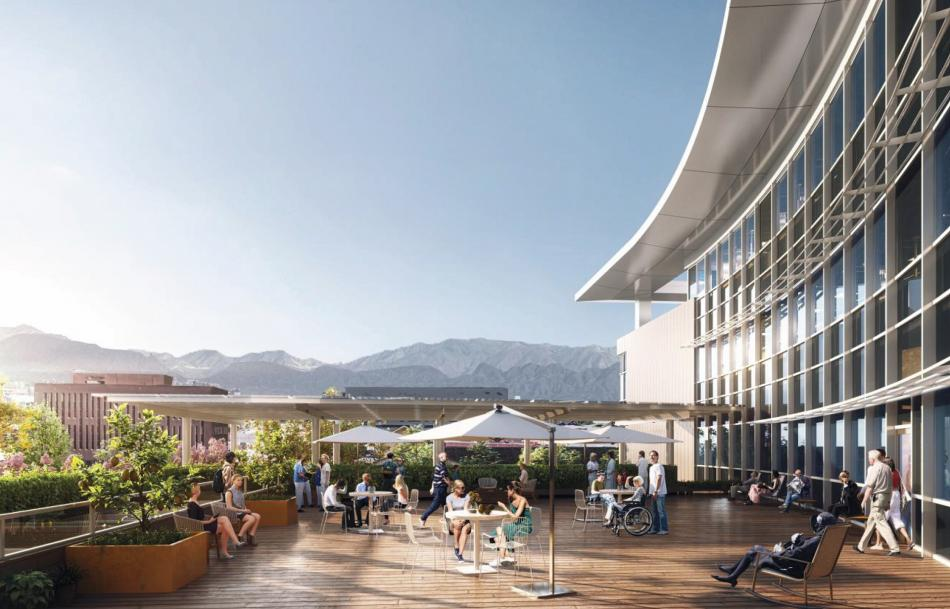

Comments: [{'id': 'post-5824414306', 'author': 'Jeff', 'content': 'Love the changes!', 'timestamp': 'Monday, April 11, 2022 5:35 PM', 'parent_id': 'comment-5824414306'}, {'id': 'post-5825114146', 'author': 'ARoH', 'content': "It's definitely a lot less sterile. Love the more pedestrian-first entry.", 'timestamp': 'Tuesday, April 12, 2022 12:14 PM', 'parent_id': 'comment-5824414306'}, {'id': 'post-5922684188', 'author': 'klunkerboy', 'content': 'Site demolished as of yesterday', 'timestamp': 'Tuesday, July 19, 2022 3:49 PM', 'parent_id': None}, {'id': 'post-5917424474', 'author': 'klunkerboy', 'content': "I'm actually amazed they were finally able to buy out the hold-out massage parlor that was on the corner.", 'timestamp': 'Thursday, July 14, 2022 1:15 PM', 'parent_id': 'comment-5917424474'}, {'id': 'post-5936333639', 'author': 'Keith K.', 'content': "That's a different development at the corner of Fair Oaks and California. This one is a little over a block south.", 'timestamp': 'Wedne

In [37]:
def pull_article_data(url):
  driver.get(url)

  wait.until(EC.presence_of_element_located((By.CLASS_NAME, "article-lead-image")))

  #get lead image
  lead_image_div = driver.find_element(By.CLASS_NAME, "article-lead-image")
  lead_image = lead_image_div.find_element(By.TAG_NAME, "img")
  lead_image_url = lead_image.get_attribute('src')

  image_urls = [lead_image_url] if lead_image_url else []

  
  wait.until(EC.presence_of_element_located((By.TAG_NAME, "body")))

  #get other images
  images = driver.find_elements(By.XPATH, "//img[@class='image-950w article-inline-image']")
  
  for image in images:
      src = image.get_attribute('src')
      if src:
          image_urls.append(src)
  

  #get h1 class = "article-title"
  article_title = driver.find_element(By.CSS_SELECTOR, "h1.article-title").text

  #get h2 class = " article-subtitle"
  article_subtitle = driver.find_element(By.CSS_SELECTOR, "h2.article-subtitle").text

  #get p in class="article-body"
  article_body_div = driver.find_element(By.CSS_SELECTOR, "div.article-body")
  paragraphs = article_body_div.find_elements(By.CSS_SELECTOR, "p:not(.image-and-caption)")
  article_body = "\n".join([p.text for p in paragraphs])


  #get comment    
  wait.until(EC.presence_of_element_located((By.TAG_NAME, "iframe")))
    
  #switch to  iframe
  iframe = driver.find_element(By.TAG_NAME, "iframe")
  driver.switch_to.frame(iframe)
    
  wait.until(EC.presence_of_element_located((By.ID, "post-list")))
  comments = driver.find_elements(By.CSS_SELECTOR, "li.post")
    
  comment_data = []
    
  for comment in comments:
        comment_id = comment.get_attribute("id")
        author = comment.find_element(By.CSS_SELECTOR, "span.author").text
        content = comment.find_element(By.CSS_SELECTOR, "div.post-message").text
        timestamp = comment.find_element(By.CSS_SELECTOR, "a.time-ago").get_attribute("title")
        
        parent_link = comment.find_elements(By.CSS_SELECTOR, "a.parent-link")
        parent_id = parent_link[0].get_attribute("href").split("#")[-1] if parent_link else None
        
        # Store comment data
        comment_data.append({
            "id": comment_id,
            "author": author,
            "content": content,
            "timestamp": timestamp,
            "parent_id": parent_id
        })
    
    # driver.switch_to.default_content()
    
  return article_title, article_subtitle, article_body, image_urls, comment_data







article_title, article_subtitle, article_body, image_urls, comment_data = pull_article_data('https://la.urbanize.city/post/updated-look-new-huntington-hospital-medical-offices')


print("Article Title:", article_title)
print("Article Subtitle:", article_subtitle)
print("Article Body:", article_body)
for i, url in enumerate(image_urls, 1):
      print(f"Image {i}: {url}")
  

for image_url in image_urls:
    response = requests.get(image_url)
    if response.status_code == 200:
        display(Image(response.content))

print("Comments:", comment_data)